## Import Libraries

In [ ]:
!pip install imageio

In [27]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from imageio import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


## Load Data

In [ ]:
def all_data(data_path):
    classes, class_path = zip(*[ (label , os.path.join(data_path, label, image) ) 
                               for label in os.listdir(data_path)[:-1] if os.path.isdir(os.path.join(data_path,label))
                                for image in os.listdir(os.path.join(data_path,label))
                               ])

    df_all = pd.DataFrame({"Class Path":class_path ,"Class":classes })
    return df_all

In [ ]:
df = all_data("/kaggle/input/brain-mri-images-for-brain-tumor-detection")
rand_images = df.sample(10)
rand_images

,Class Path,Class
197,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
126,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
101,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
234,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
6,/kaggle/input/brain-mri-images-for-brain-tumor...,no
94,/kaggle/input/brain-mri-images-for-brain-tumor...,no
67,/kaggle/input/brain-mri-images-for-brain-tumor...,no
178,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
10,/kaggle/input/brain-mri-images-for-brain-tumor...,no
230,/kaggle/input/brain-mri-images-for-brain-tumor...,yes


## Show Data

In [ ]:
def plot_images(rand_images):
    
    plt.figure(1, figsize=(15, 9))
    plt.axis("off")
    n = 0
    for path, label in rand_images.values:
        n += 1
        img = imread(path)
        ax = plt.subplot(2, 5 ,n)
        ax.set_title(label)
        plt.axis("off")
        plt.imshow(img)
    plt.show()

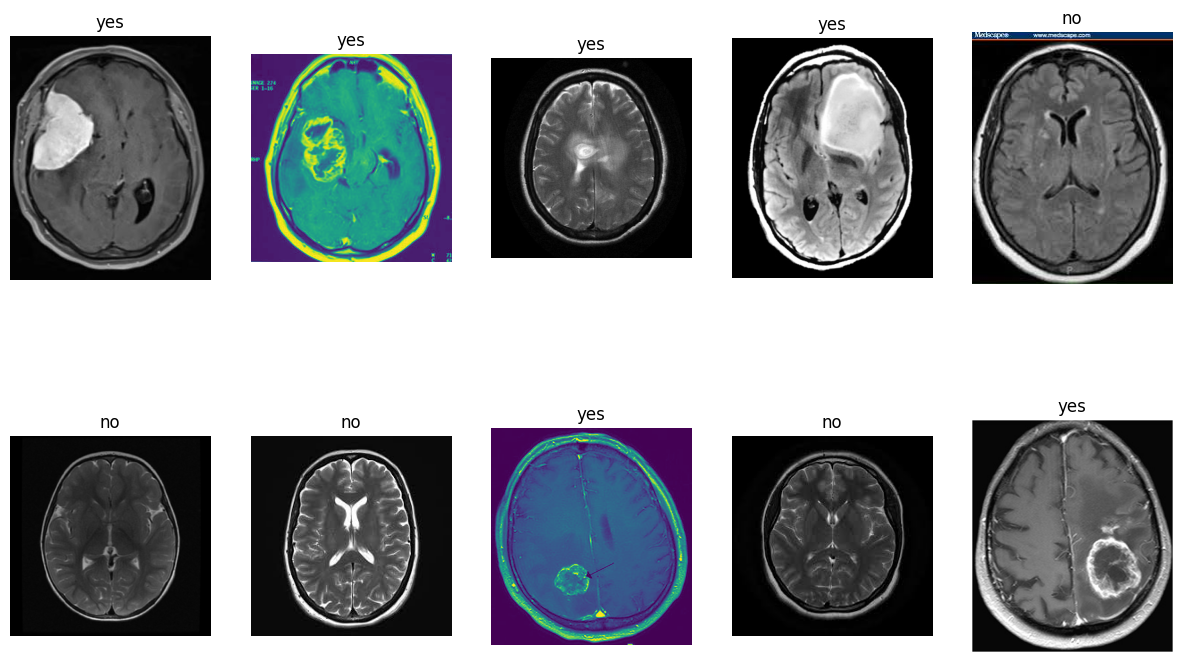

In [ ]:
plot_images(rand_images)

In [ ]:
df["Class"].value_counts()

Class
yes    155
no      98
Name: count, dtype: int64

<BarContainer object of 2 artists>

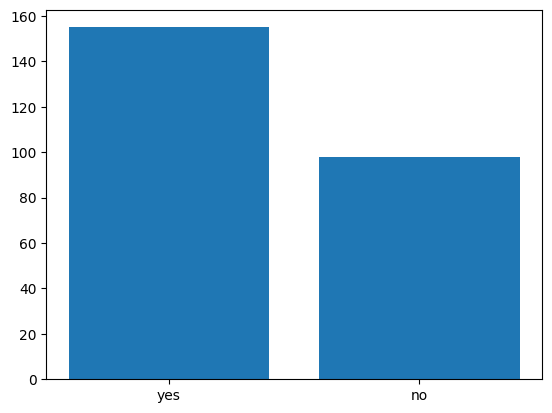

In [ ]:
index , value = zip(*df["Class"].value_counts().items())
plt.bar(index, value)

## Split Data

In [ ]:
train_df ,test_df = train_test_split(df, test_size=0.2, random_state=42 , stratify=df["Class"])

In [ ]:
test_df["Class"].value_counts()

Class
yes    31
no     20
Name: count, dtype: int64

In [ ]:
# val_df ,test_df = train_test_split(test_df, test_size=0.2, random_state=42 , stratify=test_df["Class"])

## Image Processing

In [ ]:
tr_datagen = ImageDataGenerator(
    rotation_range=30,             
    width_shift_range=0.15,         
    height_shift_range=0.15,        
    shear_range=0.15,               
    zoom_range=0.15,                
    horizontal_flip=True,           
    vertical_flip=False,            
    fill_mode='nearest',            
    brightness_range=[0.8, 1.2],    
    channel_shift_range=20,
)

_gen = ImageDataGenerator()



train_gen = tr_datagen.flow_from_dataframe(
    train_df,
    x_col = "Class Path",
    y_col = "Class",
    batch_size = 32,
    seed = 123,
    color_mode = "rgb",
    target_size = (224,224),
)

test_gen = _gen.flow_from_dataframe(
    test_df,
    x_col = "Class Path",
    y_col = "Class",
    batch_size = 32,
    target_size = (224,224),
    shuffle=False
)


Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
import cv2
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None 
    img = cv2.resize(img, (224, 224))
    img = preprocess_input(img)
    return img

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.metrics import Recall, Precision
from keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50

In [ ]:

base = ResNet50(include_top = False, weights="imagenet", input_shape=(224,224,3), pooling="max")

for layer in base.layers:
    layer.trainable = False


In [ ]:
model = Sequential([

    base,
    Flatten(),
    Dense(224, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.2),
    Dense(2, activation="softmax")
])


In [ ]:
model.compile(Adamax(learning_rate=0.001),
             loss="categorical_crossentropy",
             metrics=['accuracy',Precision(),Recall()])

In [ ]:

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
mc = ModelCheckpoint('./output/brain_Tumor_model_v2.h5', monitor='val_accuracy',mode='max')

In [ ]:
hist = model.fit(train_gen,validation_data=test_gen,verbose=1,callbacks=[es,mc],epochs=50)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8394 - loss: 0.5980 - precision_3: 0.8394 - recall_3: 0.8394 - val_accuracy: 0.8431 - val_loss: 0.5150 - val_precision_3: 0.8431 - val_recall_3: 0.8431
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 586ms/step - accuracy: 0.9159 - loss: 0.2288 - precision_3: 0.9159 - recall_3: 0.9159 - val_accuracy: 0.8431 - val_loss: 0.6898 - val_precision_3: 0.8431 - val_recall_3: 0.8431
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 594ms/step - accuracy: 0.9344 - loss: 0.1495 - precision_3: 0.9344 - recall_3: 0.9344 - val_accuracy: 0.8627 - val_loss: 0.4746 - val_precision_3: 0.8627 - val_recall_3: 0.8627
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 588ms/step - accuracy: 0.9622 - loss: 0.1236 - precision_3: 0.9622 - recall_3: 0.9622 - val_accuracy: 0.8627 - val_loss: 0.4290 - val_precision_3: 0.8627 - val_recall_3: 0.8627
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 584ms/step - accuracy: 0.9295 - loss: 0.2208 - precision_3: 0.9295 - recall_3: 0.9295 - val_accurac

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/working/output/brain_Tumor_model_v2.h5')

In [ ]:
# Evaluate the model
accuracy = model.evaluate(test_gen)
# print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8799 - loss: 0.3871 - precision_3: 0.8799 - recall_3: 0.8799
Test Accuracy: [0.4040091335773468, 0.8823529481887817, 0.8823529481887817, 0.8823529481887817]


In [ ]:

test_df["Class"].value_counts()

Class
yes    31
no     20
Name: count, dtype: int64

In [ ]:
# Predict on test data
pred = model.predict(test_gen)
pred = (pred > 0.5).astype("int32")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


In [ ]:
# Convert one-hot to class labels
pred_labels = np.argmax(pred, axis=1)

In [ ]:
true_data = np.array(test_df["Class"].map({"yes":1,"no":0}))

In [ ]:
true_data

array([0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1])

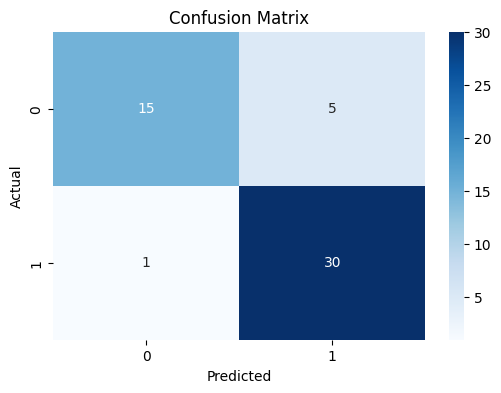

In [ ]:
# Confusion matrix
cm = confusion_matrix(true_data, pred_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
print("Classification Report:\n", classification_report(true_data, y_pred_labels))

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.75      0.83        20
           1       0.86      0.97      0.91        31

    accuracy                           0.88        51
   macro avg       0.90      0.86      0.87        51
weighted avg       0.89      0.88      0.88        51



In [ ]:
# Save the model
model.save("brain_Tumor_model_v3.h5")  
print("Model saved!")

Model saved!


In [ ]:
from IPython.display import FileLink

# Provide a download link
FileLink(r'brain_Tumor_model_v3.h5')

/kaggle/working/brain_Tumor_model_v3.h5